***Warning:*** This is the second script of this project. in the first one ("eda_and_feature_engineering"), we define the problem, explored the data, we did an initial treatment and created some features. I strongly recommend that you visit the first script before exploring this one, they are two parts of the same project, and were split just to avoid an extremely large script, improving the organization.

**Method:**

As mentioned, we have already pre-treated our data. However, the EDA revealed that we have ***unbalanced data***, we need to understand witch technique should be used to train our model. In order to build the best possible model, we also need to perform feature selection. 

All considered, we decided to opt for an iterative methodology, as described below:

+ Define and prepare metrics to be easily applicable 
+ Develop a pipeline to build a model and create a baseline with the raw DataFrame
+ Treat the imbalance data problem and choose the best technique
+ Feature selection and engineering
+ Model selection and hyperparameter tuning


# Libs

In [296]:
import pandas as pd 
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier

# Metrics

**Defining metrics**

Evaluating a classification model may not be the easiest task. In order to obtain a consistent result it will be necessary to use a set of metrics, we will adopt:

+ recall -- Indicates the occurrence of false negative, e.g, predict indicated that default would NOT occur, but it did
+ precision -- Indicates rate at which positive predictions are correct, e.g, predict indicated that default would occur, and it did
    + Please note: in our case, **recall will have greater relevance**, because predicting a false negative will result in greater losses for the business than predicting a false positive
+ F1 -- A function of Precision and Recall. Even though Recall is more important, precision is also relevant, because wrongly predicting that a default will happen, also results in business loses. So it is good to have a metric that represents a balance between Precision and Recall. 
+ ROC Curve -- Until now, our metrics are considering 3 of 4 values of the confusion matrix, we are not looking at true negatives! We could use Accuracy or Specificity to include true negative in our analyses, but we expected that the majority of data will be true negative, so those metrics may be misleading. Instead, we will use the ROC curve, that shows the relation between  True Positive Rate and True Negative Rate. 
+ AUC -- Its the area under the ROC curve, it is a simple way to measure the ROC Curve.


***To make our life easier, let's define a class that calculates and displays all the desired metrics***

In [244]:
class metrics:
    
    def __init__(self, y_true,y_pred):
        
        """Create the metrics object and define the desired metrics as attributes.

        Keyword arguments:
        y_true -- list of predict default
        y_pred -- list of actual default
        """
        
        self.y_pred = y_pred
        self.y_true = y_true
        
        # Recall --  Tp / (Tp + Fn) or (True positive/Total Actual Positive)
        self.recall = recall_score(y_true, y_pred)
        # Precision -- Tp/(Tp + Fp) or (True positive/Total Predicted Positive)
        self.precision = precision_score(y_true, y_pred) 
        # F1 -- 2*precision*recall /(precision + recall)
        self.f1 = 2*self.precision*self.recall/(self.precision+self.recall)
        # AUC - area under roc curve
        self.auc = roc_auc_score(y_true, y_pred)
        # Values of: tp,tn,fp,fn
        self.conf_matrix = confusion_matrix(self.y_true, self.y_pred)
        
    def show_metrics(self):
        
        """Print metrics"""
        
        print(f'Métrics:\n\nRecall: {round(self.recall,3)}'
              f'\nPrecision: {round(self.precision,3)}'
              f'\nF1: {round(self.f1,2)}'
              f'\nAUC: {round(self.auc,2)}')
        
    def show_charts(self, chart = 'all'):
        
        """plot metrics charts
        Charts may be: Confusion Matrix, ROC Curve or both
        
        Keyword arguments:
        chart -- string to define what metric to plot. Can be: 'roc','conf_matrix' or 'all' (default 'all')
        """
        
        if chart == 'all':
            fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
        elif chart == 'conf_matrix':
            fig, ax1 = plt.subplots(figsize=(5,5))
        elif chart == 'roc':
            fig, ax2 = plt.subplots(figsize=(9,5))
        else:
            return print("Please choose a valid chart value: 'conf_matrix', 'roc' or 'all'")
        
        if chart == 'all' or chart == 'conf_matrix':
            # Confusion Matrix plot
            ConfusionMatrixDisplay(self.conf_matrix).plot(ax =ax1)
            ax1.set_title("Confusion Matrix",fontsize = 18)
            ax1.set_xlabel("Predicted Default",fontsize=14)
            ax1.set_ylabel("Actual Default",fontsize=14)
            ax1.tick_params(labelsize=12)
            
        if chart == 'all' or chart == 'roc':
            # ROC curve plot
            RocCurveDisplay.from_predictions(self.y_true,self.y_pred,ax = ax2)
            ax2.set_title("ROC Curve",fontsize = 18)
            ax2.set_xlabel("False Positive Rate (Specificity)",fontsize=14)
            ax2.set_ylabel("True Positive Rate (Recall)",fontsize=14)
            ax2.tick_params(labelsize=12)
            
        plt.show()
   
    
    def show_all(self):
        
        """Plot metrics chart and print metrics values.
        *Confusion Matrix
        *ROC Curve
        *Recall
        *Precision
        *F1
        """
        
        self.show_charts()
        self.show_metrics()


***To prevent overfitting, we will use Stratified K-Folds cross-validator to evaluate our models. Therefore, it will be interesting to have a function that receive multiple metrics objects (one for each fold) and generate overlapped charts, mean metrics, and other useful infos.***

In [241]:
def show_mean_metrics(metrics_obj_list):

    """Show mean metrics for multiple tests (K-Folds)
    for n folds:
    Plot overlapped ROC Curve
    Plot sum of Confusion Matrix or both
    print defined metrics and respective standard deviations

    Keyword arguments:
    metrics_obj_list -- list of object from metrics class
    """
    
    # Empty arrays to sum Confusion Matrix values from all folds
    conf_matrix_s1 = np.array([0,0])
    conf_matrix_s2 = np.array([0,0])       

    # mean_fpr and tprs will be used to define the mean ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    # Lists to append individual metrics of each fold
    recall_list,precision_list,f1_list,auc_list = [[]for i in range(4)]
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    for metrics_obj, i in zip(metrics_obj_list,range(len(metrics_obj_list))):
        
        # Appending metrics values
        recall_list.append(metrics_obj.recall)
        precision_list.append(metrics_obj.precision)
        f1_list.append(metrics_obj.f1)
        auc_list.append(metrics_obj.auc)
        
        # sum Confusion Matrix values
        conf_matrix_s1 = conf_matrix_s1 + metrics_obj.conf_matrix[0]
        conf_matrix_s2 = conf_matrix_s2 + metrics_obj.conf_matrix[1]
        
        # Creating a overlapped ROC curve
        viz = RocCurveDisplay.from_predictions(metrics_obj.y_true,
                                               metrics_obj.y_pred,
                                               name=f"ROC fold {i+1}",lw = 1,alpha=0.4,
                                               ax = ax2)
        
        # creating 100 interpelated points between True positive rates and true negative rates 
        # This is the best way to calculate the mean roc curve, 
        # for more info, please visit https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
   
    # Mean points for all folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    ax2.plot(mean_fpr,mean_tpr,color="#2349de",
             label =f"Mean ROC (mean AUC = {round(np.mean(auc_list),2)})",
             lw=2, alpha=0.8)
    
    
    # Defining variance around mean ROC Curve to build confidence intervals
    std_tpr = np.std(tprs, axis=0) # Std value for each interpolated point
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1) # Point + std
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0) # Point - std
    ax2.fill_between(mean_fpr,tprs_lower,tprs_upper,color="grey",alpha=0.1,label=r"$\pm$ 1 std. dev.") # Plot interval
    
    
    # Ploting final Confusion Matrix -- sum of all Confusion Matrix of each fold
    final_conf_matrix = np.array([conf_matrix_s1,conf_matrix_s2])
    ConfusionMatrixDisplay(final_conf_matrix).plot(ax =ax1)
    
    # Charts parameters
    # Confusion Matrix
    ax1.set_title("Confusion Matrix (Sum values for all folds)",fontsize = 18)
    ax1.set_xlabel("Predicted Default",fontsize=14)
    ax1.set_ylabel("Actual Default",fontsize=14)
    ax1.tick_params(labelsize=12)
    # ROC Curve
    ax2.set_title("ROC Curve",fontsize = 18)
    ax2.set_xlabel("False Positive Rate (Specificity)",fontsize=14)
    ax2.set_ylabel("True Positive Rate (Recall)",fontsize=14)
    ax2.tick_params(labelsize=12)
    
    plt.legend()
    plt.show()
    
    # Print mean metrics
    print(f'Métrics:\n\nMean Recall = {round(np.mean(recall_list),2)} | Recall Std = {round(np.std(recall_list),2)}'
          f'\nMean Precision = {round(np.mean(precision_list),2)} | Precision Std = {round(np.std(precision_list),2)}'
          f'\nMean F1 = {round(np.mean(f1_list),2)} | F1 Std = {round(np.std(f1_list),2)}'
          f'\nMean AUC = {round(np.mean(auc_list),2)} | AUC Std = {round(np.std(auc_list),2)}')
    

In [242]:
metrics_test = metrics([1,0,0,1,0,0,1],[1,0,0,1,0,0,0])
metrics_test2 = metrics([0,0,0,1,0,0,1],[1,0,0,1,0,0,0])
metrics_test3 = metrics([1,0,0,1,0,1,1],[0,1,0,1,0,0,0])

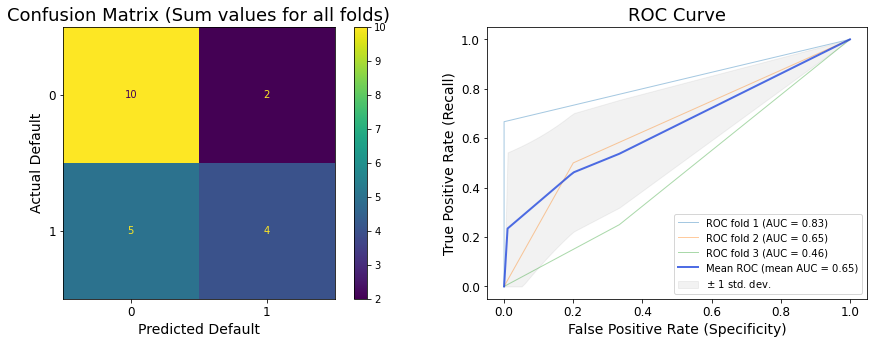

Métrics:

Mean Recall = 0.47 | Recall Std = 0.17
Mean Precision = 0.67 | Precision Std = 0.24
Mean F1 = 0.54 | F1 Std = 0.19
Mean AUC = 0.65 | AUC Std = 0.15


In [243]:
show_mean_metrics([metrics_test,metrics_test2,metrics_test3])

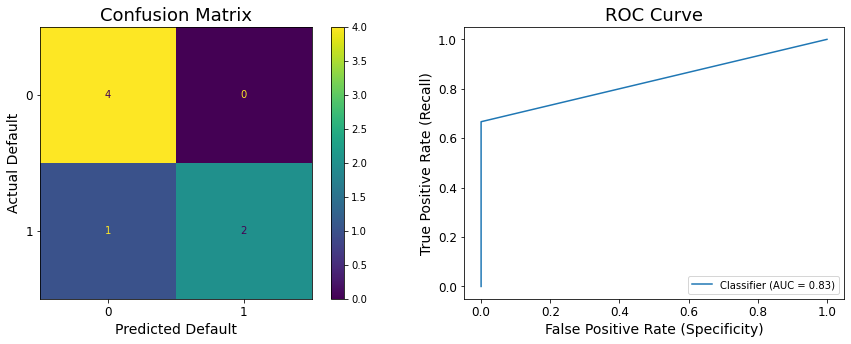

Métrics:

Recall: 0.667
Precision: 1.0
F1: 0.8
AUC: 0.83


In [237]:
metrics_test.show_all()

# Building the model

In [246]:
default_credit_card = pd.read_csv(r'data\default_of_credit_card_clients_treated.csv')
default_credit_card.head(3)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,age_range,age_range_int
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,689,0,0,0,0,1,23-25,19
1,120000,2,2,2,26,-1,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,1,25-26,6
2,90000,2,2,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,33-34,5


In [293]:
def model_metrics(X,y):
    
    """Return a list of objects from metrics class 
    * Divide data with Stratified KFold in 10 folds
    * Train a Random Forest Classifier model for each fold with train data
    * For each model, predict y with test data 
    * For each model, create a metrics object with actual and predicted y

    Keyword arguments:
    X -- Independent features (excluding target variable)
    y -- Dependent variable (target)
    """

    skf = StratifiedKFold(n_splits=10, shuffle=True)

    metrics_list =[]
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        rfc = RandomForestClassifier(max_depth=2, random_state=0)
        rfc.fit(X_train, y_train)
        
        rfc_predict = rfc.predict(X_test)
        
        prov_metrics = metrics(y_test,rfc_predict)
        metrics_list.append(prov_metrics)
    
    return metrics_list

In [294]:
X  = default_credit_card.loc[:,default_credit_card.columns[:23].tolist()]
y = default_credit_card.default_payment_next_month

In [297]:
metrics_list = model_metrics(X,y)

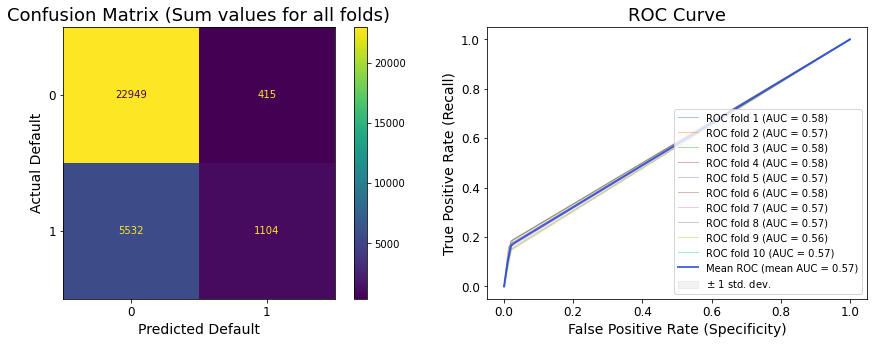

Métrics:

Mean Recall = 0.17 | Recall Std = 0.01
Mean Precision = 0.73 | Precision Std = 0.03
Mean F1 = 0.27 | F1 Std = 0.02
Mean AUC = 0.57 | AUC Std = 0.01


In [298]:
show_mean_metrics(metrics_list)